In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F



import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm_

import imageio
import os
import glob

import  source.model.model 


import tensorflow_docs.vis.embed as embed

import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)


In [4]:
model = torch.load('/home/zdelbari/HDPS/source/Experiments/engaged_phi_psi_from_start/base_model_with_regu_wb_each10_10HiddenUnits_seed92_phi0.0006/10000_batch_size/PSI0.04/lambda0.01/AdamW_lr:0.001/model/epoch999/model.pt')

ModuleNotFoundError: No module named 'model'

In [13]:
torch.tensor(list(range(0,1001, 100)))
 

tensor([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])

In [22]:
torch.exp(-1e-4 * torch.tensor(list(range(0,1001, 100)))) 

tensor([1.0000, 0.9900, 0.9802, 0.9704, 0.9608, 0.9512, 0.9418, 0.9324, 0.9231,
        0.9139, 0.9048])

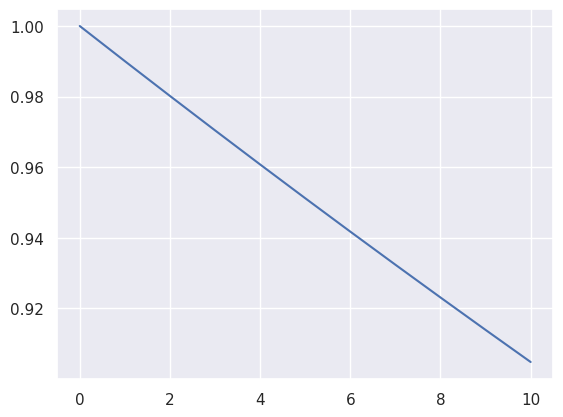

In [19]:
plt.plot(torch.exp(-1e-4 * torch.tensor(list(range(0,1001, 100)))))


In [23]:
import numpy as np

def sample_gumbel(shape, eps=1e-20):
    """Sample from Gumbel(0, 1) distribution."""
    U = np.random.uniform(0, 1, shape)
    return -np.log(-np.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    """Draw a sample from the Gumbel-Softmax distribution."""
    gumbel_noise = sample_gumbel(logits.shape)
    y = logits + gumbel_noise
    return softmax(y / temperature)

def softmax(logits):
    """Compute the softmax of the logits."""
    exp_logits = np.exp(logits - np.max(logits, axis=-1, keepdims=True))
    return exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)

def gumbel_softmax(logits, temperature, num_samples):
    """Generate multiple Gumbel-Softmax samples."""
    samples = [gumbel_softmax_sample(logits, temperature) for _ in range(num_samples)]
    return np.array(samples)

# Example usage
logits = np.array([2.0, 1.0, 0.3])  # Logits for a categorical distribution
temperature = 0.5  # Temperature parameter
num_samples = 5  # Number of samples to generate

samples = gumbel_softmax(logits, temperature, num_samples)
print("Gumbel-Softmax samples:")
print(samples)


Gumbel-Softmax samples:
[[9.92868569e-01 9.44617798e-04 6.18681320e-03]
 [1.10754727e-02 9.86332730e-01 2.59179725e-03]
 [6.98510132e-01 1.96138568e-01 1.05351299e-01]
 [5.56596541e-02 9.13694732e-01 3.06456143e-02]
 [8.17289532e-03 9.91804264e-01 2.28409776e-05]]


In [2]:
from Parameters import *
from functions import *
from torch.utils.data import DataLoader, TensorDataset

prob = torch.tensor([P_EDU] * J)
ep_t_e = e((J, T_LR-AGE_0))
theta_t_e = torch.cumsum(ep_t_e, dim=-1) + THETA_0
edu_e = torch.bernoulli(prob)
u_t_e = mu(edu_e.unsqueeze(1), torch.arange(1, T_LR-AGE_0 + 1))
w_t_e = wage(u_t_e, theta_t_e)
dataset_eval = TensorDataset(theta_t_e, w_t_e, edu_e)
dataloader_eval = DataLoader(dataset_eval, batch_size=100000)

In [3]:
from utils import *
def do_eval_save(model, dataloader, device):
  
    
    
    all_w = []
    all_a = []
    all_h = []
    all_y = []
    all_c = []
    all_p = []
    all_t = []
    all_edu = []
    all_theta = []
    model.eval()

    for batch_idx, batch in enumerate(dataloader):
        with torch.no_grad():

            theta_t, w_t, edu = batch
            
            w_t = w_t.to(device)
            len_batch = len(batch[0])
            a_1 = torch.tensor([A_1]* len_batch)
            
            a_t, c_t_e, all_c_ER, pr, all_pr, h_t, y_t  = model(theta_t.to(device), edu.to(device), a_1.to(device),w_t)
            all_c_r = (1-pr) * ( all_pr * all_c_ER[:,:,1] + (1-all_pr) * all_c_ER[:,:,0]) +  pr * all_c_ER[:,:,2]
            
            c_t = torch.concat([c_t_e[:, :T_ER - AGE_0], all_c_r,c_t_e[:, T_LR - AGE_0+1:] ], dim = -1)
        

            all_w.extend(w_t.cpu())
            all_edu.extend(edu.cpu())
            
            all_theta.extend(theta_t.cpu())
            
            all_a.extend(a_t.cpu())
            all_h.extend(h_t.cpu())
            all_y.extend(y_t.cpu())
            all_c.extend(c_t.cpu())
            all_p.extend(pr.cpu())
            # all_t.extend(r_t.cpu())
            
            
    all_w = torch.stack(all_w)
    all_a = torch.stack(all_a)
    all_h = torch.stack(all_h)
    all_y = torch.stack(all_y)  
    all_c = torch.stack(all_c)
    all_theta = torch.stack(all_theta)
    all_p =  torch.stack(all_p)
    all_edu = torch.stack(all_edu)
    return   all_a, all_h, all_w, all_c, all_y, all_p, all_edu, all_theta
    
    # utility_retirement(all_c, all_h, epoch, s_writer,args, mode='eval')
    # draw_all_plots(base_dir, all_a, all_h, all_w, all_theta, all_c, all_y)

In [44]:
def Histogram_Retirement_Age(p, edu,  plots_base_dir = None, epoch = None, save = False):
    age_retirement = torch.concat([p, torch.ones((len(p), 1))], dim = -1).argmax(dim = -1)+ T_ER - 1 
    plt.hist(age_retirement[edu<=0], bins = 8, range=(62,70),edgecolor='orange', alpha= .4, label='edu = 0')
    plt.hist(age_retirement[edu>0], bins= 8, range=(62,70), edgecolor='skyblue', alpha= .8, label='edu = 1')

        
    plt.legend()
    
    if save:
        dir_save = f'{plots_base_dir}/epoch{epoch}/histograms'
        pathlib.Path(dir_save).mkdir(parents=True, exist_ok=True)
        plt.savefig(f'{dir_save}/hist_age_retirement.png')
        plt.close()
        return 

In [2]:
device = 'cuda'
base_dir  = f'/home/zdelbari/HDPS/Experiments/multiple_r--with_tax--gumbel--phi_0.0006--tau_0.01/base_model_with_regu_wb_each10_10HiddenUnits_seed92_phi0.0006/10000_batch_size/PSI0.04/lambda0.01/AdamW_lr:0.001'
model = torch.load(f'{base_dir}/model/epoch999/model.pt')
model.to(device)

all_a, all_h, all_w, all_c, all_y, all_p, all_edu, all_theta = do_eval_save(model, dataloader_eval, device)


ModuleNotFoundError: No module named 'model'

In [64]:
def plot_trend(data, edu, mask_retirement, type, func,plots_base_dir= None, epoch = None, save = False):
    
    plt.figure(figsize=(15,7))


    
    if func == 'mean':
        
          
            weights_edu_0 = torch.concat( [torch.ones((T_ER - AGE_0)) * len(data[edu<=0]) , mask_retirement[edu<=0].sum(dim=0)], dim = 0) 
            weights_edu_1 = torch.concat( [torch.ones((T_ER - AGE_0)) * len(data[edu>0]) , mask_retirement[edu>0].sum(dim=0)], dim = 0) 
            
            plt.plot( data[edu > 0][:,:T_LR].sum(dim=0)/weights_edu_1, color='skyblue', label='edu = 1')
            plt.plot( data[edu <= 0][:,:T_LR].sum(dim=0)/weights_edu_0, color='orange', label='edu = 0')
            # plt.xticks(AGE_0, T_LR+1)

            
            # plt.plot( range(AGE_0, len(data[0]) + AGE_0), data[edu > 0][mask_all].mean(dim=0), color='skyblue', label='edu = 1')
            # plt.plot( range(AGE_0, len(data[0]) + AGE_0), data[edu <= 0].mean(dim=0), color='orange', label='edu = 0')
  
  
        
    elif func == 'median':
        
        if type in ['Income', 'Work_Hour']:
            plt.plot( torch.concat([data[edu > 0][:,T_ER].median(dim=0).values], axis = 1), color='skyblue', label='edu = 1')
            plt.plot( range(AGE_0, len(data[0]) + AGE_0), data[edu <= 0].median(dim=0).values, color='orange', label='edu = 0')

            
        elif type in ['Consumption', 'Asset']:
            plt.plot( range(AGE_0, len(data[0]) + AGE_0), data[edu > 0].median(dim=0).values, color='skyblue', label='edu = 1')
            plt.plot( range(AGE_0, len(data[0]) + AGE_0), data[edu <= 0].median(dim=0).values, color='orange', label='edu = 0')

         
    plt.legend()
    plt.title(f'Trend of {type}') 
    if save:
        dir_save = f'{plots_base_dir}/epoch{epoch}/trend'
        pathlib.Path(dir_save).mkdir(parents=True, exist_ok=True)
        plt.savefig(f'{dir_save}/trend_{type}_{func}.png')
        plt.close()
        

In [60]:
(all_p[:, 1:]== 0).sum(dim = 0)

tensor([391655, 290414, 209813, 119887,  51716,  29107,  11222,      2])

In [ ]:
mask_retirement

In [67]:
plot_trend(all_y, all_edu, (all_p[:, 1:]== 0), 'Income', 'mean')

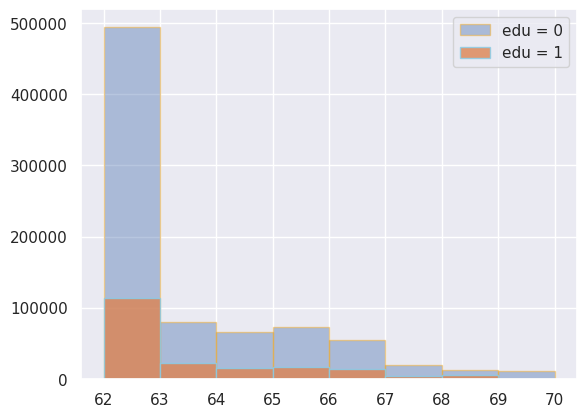

In [45]:
Histogram_Retirement_Age(all_p , all_edu)

In [13]:
all_p.argmax(dim= -1)

tensor([1, 1, 1,  ..., 1, 5, 1])

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

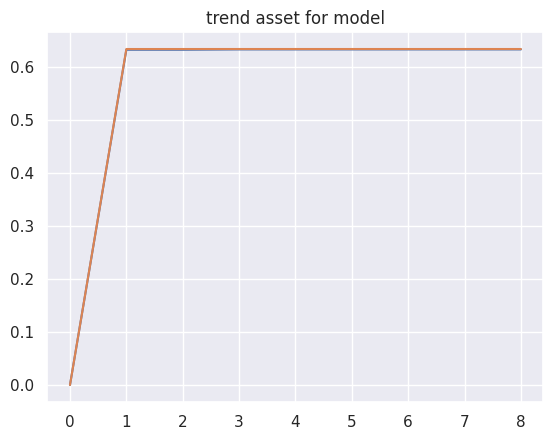

In [4]:
from model import Model
device = 'cuda'
epoch = 999

for alpha in [1, 10, 1000]:
    for phi in [0, 0.1, .001, 1]:
        
        base_dir  = f'/home/zdelbari/HDPS/Experiments/single_r--alpha_pr_{alpha}--phi_{phi}/base_model_with_regu_wb_each10_10HiddenUnits_seed92_phi{phi}/10000_batch_size/PSI0.04/lambda0.01/AdamW_lr:0.001'
        model = torch.load(f'{base_dir}/model/epoch{epoch}/model.pt')
        model.to(device)
        
        all_a, all_h, all_w, all_c, all_y, all_p, all_edu, all_theta = do_eval_save(model, dataloader_eval, device)
        
        plot_pr(all_p, all_edu,plots_base_dir = f'{base_dir}/plot', epoch = epoch, save = True)
        Histograms_Individual_Ages(all_a, all_edu, 'Asset', plots_base_dir = f'{base_dir}/plot', epoch = epoch, save = True)
        Histograms_Individual_Ages(all_c, all_edu, 'Consumption', plots_base_dir = f'{base_dir}/plot', epoch = epoch, save = True)
        Histograms_Individual_Ages(all_h, all_edu, 'Workhour', plots_base_dir = f'{base_dir}/plot', epoch = epoch, save = True)
        Histograms_Individual_Ages(all_y, all_edu, 'Income', plots_base_dir = f'{base_dir}/plot', epoch = epoch, save = True)
        
        plot_trend(all_a, all_edu, None, 'Asset', plots_base_dir = f'{base_dir}/plot', epoch = epoch, save = True)
        plot_trend(all_c, all_edu, None, 'Consumption', plots_base_dir = f'{base_dir}/plot', epoch = epoch, save = True)
        plot_trend(all_h, all_edu, None, 'Workhour', plots_base_dir = f'{base_dir}/plot', epoch = epoch, save = True)
        plot_trend(all_y, all_edu, None, 'Income', plots_base_dir = f'{base_dir}/plot', epoch = epoch, save = True)
                
        policy_function_plot_asset(model, all_edu, 'workhour', all_a, all_w,  plots_base_dir = f'{base_dir}/plot', epoch = epoch, save = True)
        policy_function_plot_asset(model, all_edu, 'Asset', all_a, all_w,  plots_base_dir = f'{base_dir}/plot', epoch = epoch, save = True)



In [8]:
path = "/home/zdelbari/HDPS/Experiments/multiple_r--with_tax--gumbel--phi_0.0005/base_model_with_regu_wb_each10_10HiddenUnits_seed92_phi0.0005/10000_batch_size/PSI0.04/lambda0.01/AdamW_lr:0.001/model/epoch999/model.pt"
model = torch.load(path)
device = 'cuda'
model.to(device)

all_a, all_h, all_w, all_c, all_y, all_p, all_edu, all_theta = do_eval_save(model, dataloader_eval, device)



In [25]:
all_p[900]

tensor([0., 1., 1., 1., 1., 1., 1., 1., 1.])

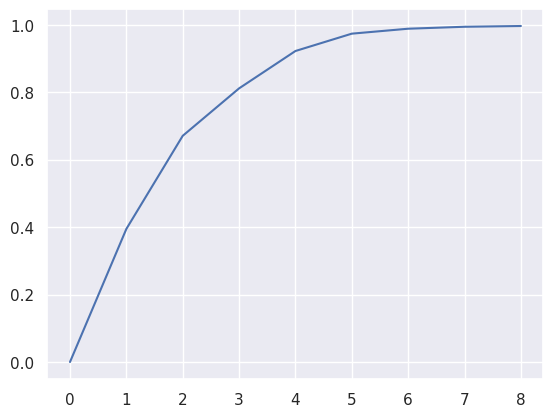

In [18]:
plt.plot(all_p.mean(dim = -2))

In [5]:
all_a, all_h, all_w, all_c, all_y, all_p, all_edu, all_theta = do_eval_save(model, dataloader_eval, device)
# all_a_s, all_h_s, all_w_s, all_c_s, all_y_s, all_p_s, all_edu_s = do_eval_save(model_steep, dataloader_eval, device)
# all_a_s_phi0, all_h_s_phi0, all_w_s_phi0, all_c_s_phi0, all_y_s_phi0, all_p_s_phi0, all_edu_s_phi0, all_theta_s_phi0 = do_eval_save(model_steep_phi0, dataloader_eval, device)


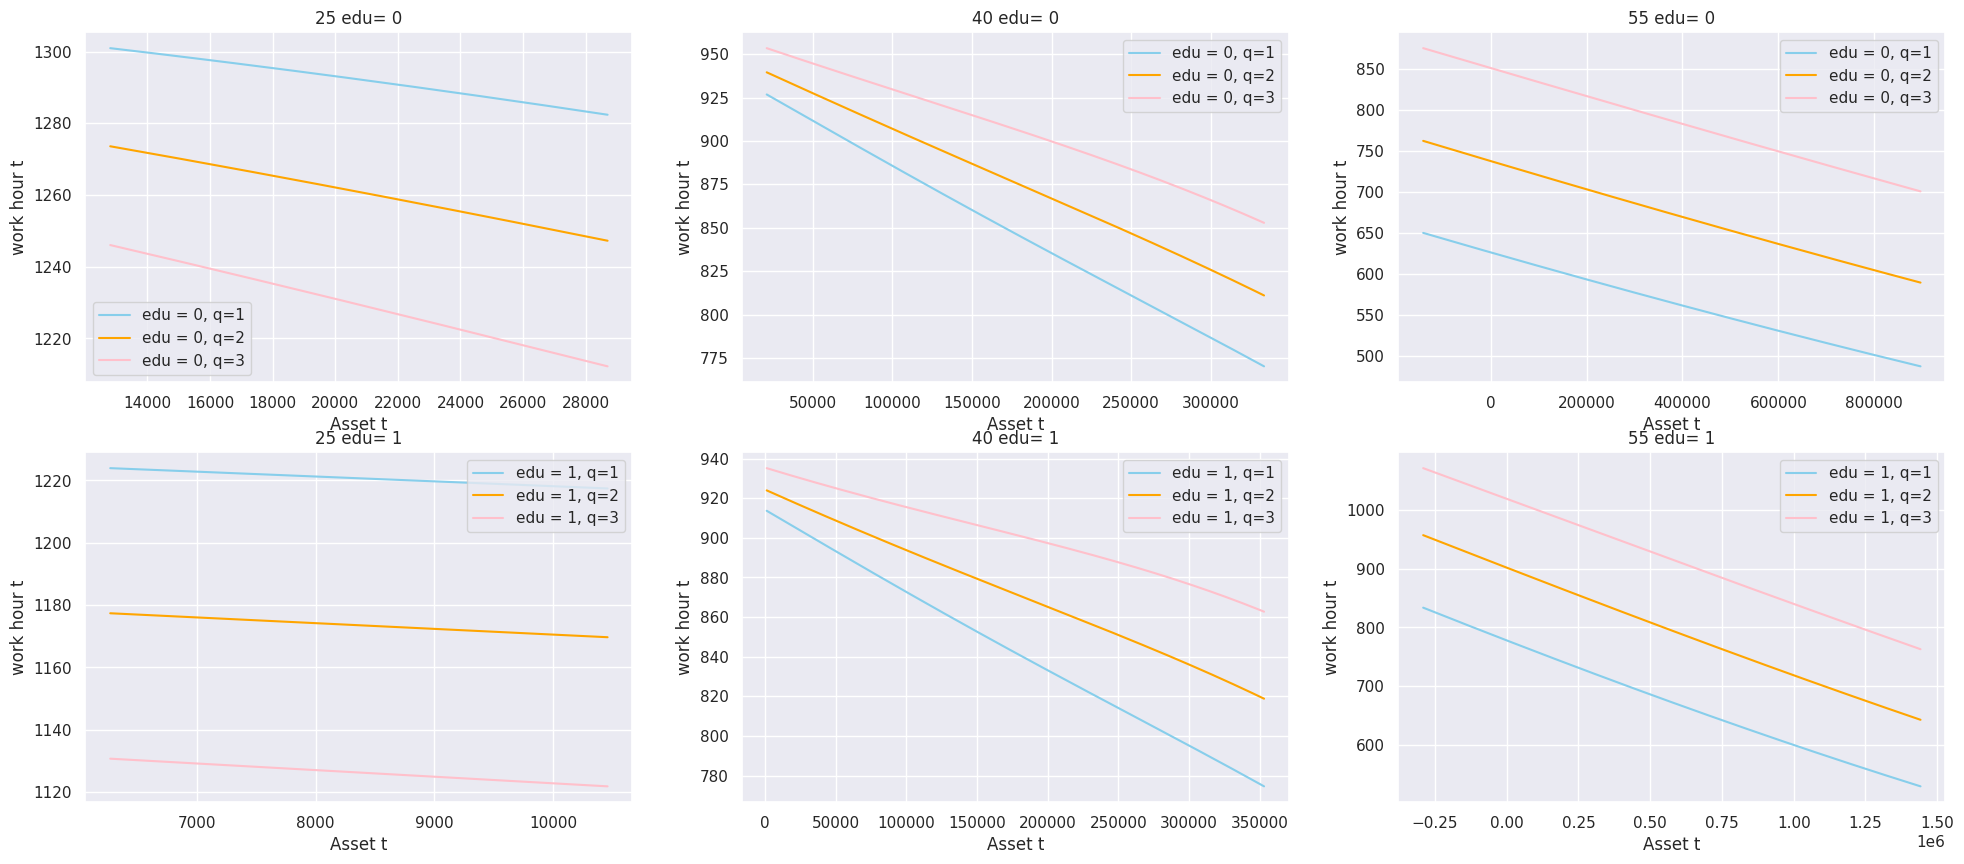

In [17]:


policy_function_plot_asset(model, all_edu, 'workhour', all_a, all_w)

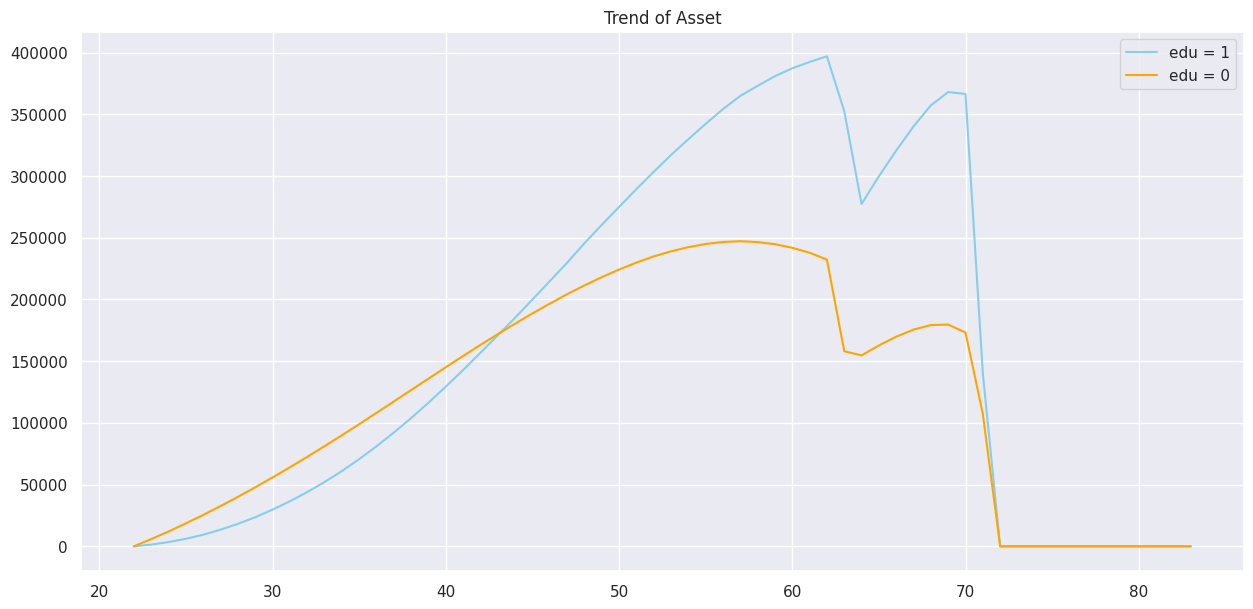

In [6]:

plot_trend(all_a, all_edu, None, 'Asset')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


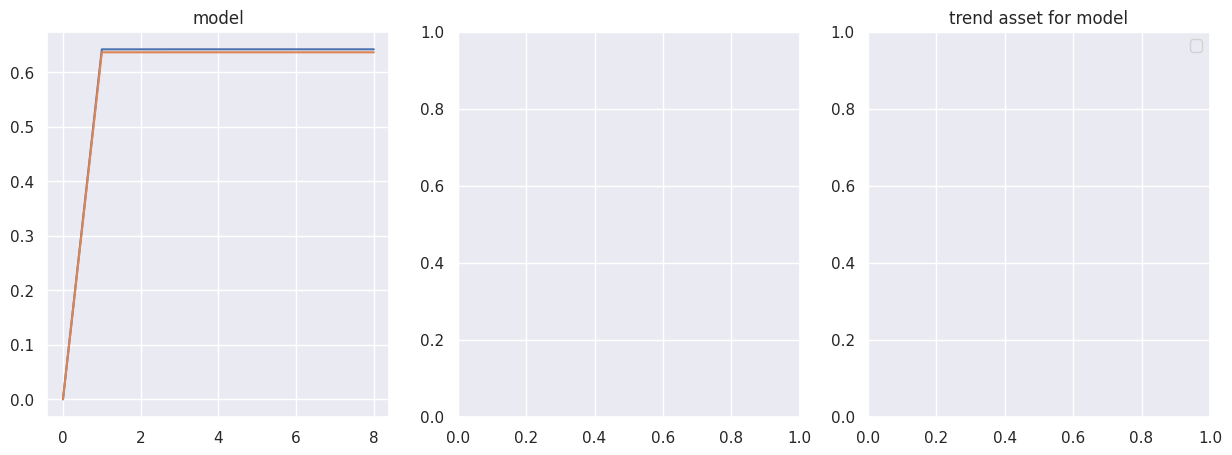

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plt.title('trend asset for model')

ax[0].plot(  all_p[all_edu>0].mean(dim=0), label='edu=1')
ax[0].plot(  all_p[all_edu<=0].mean(dim=0), label='edu=0')
ax[0].set_title('model')


plt.legend()
plt.show()

In [9]:
all_p[all_edu>0][2]



tensor([0.0000e+00, 1.2727e-13, 3.3349e-09, 6.4787e-01, 6.4787e-01, 6.4787e-01,
        6.4787e-01, 6.4787e-01, 6.4787e-01])

In [27]:
model.work_block['year_24'].general_layer_2.weight

Parameter containing:
tensor([[-0.9453,  0.2776,  0.3481, -0.1530, -0.1236,  0.0585,  0.1428, -0.2788,
          0.2546,  0.4860],
        [-0.3729, -0.0201, -0.1459,  0.0467, -0.3626, -0.1320,  0.1272,  0.2932,
         -0.0458, -0.3649],
        [ 0.3262,  0.5352, -0.3030,  0.5026,  0.0633,  0.4774, -0.5462, -0.2473,
          0.2261, -0.9361],
        [-0.1175,  0.2213,  0.2692,  0.3213,  0.2289, -0.0161, -0.2920,  0.0604,
         -0.0548, -0.1150],
        [ 0.1188,  0.1127, -0.3353, -0.2003,  0.0161, -0.1870, -0.2415, -0.4687,
         -0.3026,  0.2890],
        [ 0.4208,  0.0536, -0.1924, -0.2465, -0.7495, -0.4807, -0.8217,  0.5467,
         -0.4970, -0.6022],
        [ 0.5822,  0.1765, -0.1787, -0.6345, -0.1301,  0.1379,  0.1623,  0.2281,
         -0.1687,  0.2426],
        [ 0.0196, -0.4056,  0.2580,  0.3050, -0.1051, -0.2719,  0.4425, -0.3116,
          0.1868,  0.3186],
        [-0.3128,  0.6491, -0.3958, -0.1524, -0.2785,  0.0113,  0.3306, -1.5191,
         -0.4582,  0.4779

In [26]:
model.work_block['year_22'].general_layer_2.weight


Parameter containing:
tensor([[-3.0227e-01,  4.6028e-01,  2.6782e-01,  1.4685e-01,  2.1635e-01,
          1.0074e-01, -2.4991e-01,  2.7842e-02,  1.2765e-01,  3.4220e-02],
        [-5.9580e-01,  6.7104e-01,  1.9897e-01, -3.7824e-01,  5.7961e-01,
          1.9287e-02,  3.7203e-01, -1.0175e+00, -6.5707e-02,  7.1573e-01],
        [ 1.5353e-01, -1.4253e-01,  5.4034e-01,  5.5079e-01, -6.3483e-01,
         -9.7970e-01,  2.6835e-01, -4.8785e-01,  2.5689e-02,  6.9173e-04],
        [ 3.0764e-01, -3.3703e-01,  9.6142e-02,  9.9754e-02, -4.2866e-01,
         -5.3300e-01, -1.8047e-01, -4.7495e-01,  2.4683e-01,  6.4665e-02],
        [-3.3923e-01,  2.1752e-01, -4.4509e-02,  2.7930e-01,  3.0348e-01,
         -1.5602e-01, -3.4835e-01, -3.1897e-01,  3.5625e-01,  4.9385e-01],
        [ 5.7503e-01, -3.3936e-01, -3.3749e-01,  2.3998e-01, -3.1851e-01,
          6.7013e-01, -3.1470e-01,  8.8939e-01, -5.0457e-01, -8.6566e-01],
        [ 5.3952e-01,  4.8768e-01,  7.8707e-03, -3.0498e-03,  1.4293e-01,
          

In [ ]:
plot_trend(all_a, all_edu, mask_retirement, type, plots_base_dir, epoch)

In [ ]:

policy_function_plot(model, all_edu, None, all_a, all_w,  None, None, device)

In [44]:
all_p

tensor([[0.0000, 0.5905, 0.5905,  ..., 0.5905, 0.5905, 0.5905],
        [0.0000, 0.5786, 0.5786,  ..., 0.5786, 0.5786, 0.5786],
        [0.0000, 0.5822, 0.5822,  ..., 0.5822, 0.5822, 0.5822],
        ...,
        [0.0000, 0.5649, 0.5649,  ..., 0.5649, 0.5649, 0.5649],
        [0.0000, 0.5774, 0.5774,  ..., 0.5774, 0.5774, 0.5774],
        [0.0000, 0.5804, 0.5804,  ..., 0.5804, 0.5804, 0.5804]])

In [ ]:

Histograms_Individual_Ages(all_a, all_edu, 'Consumption')

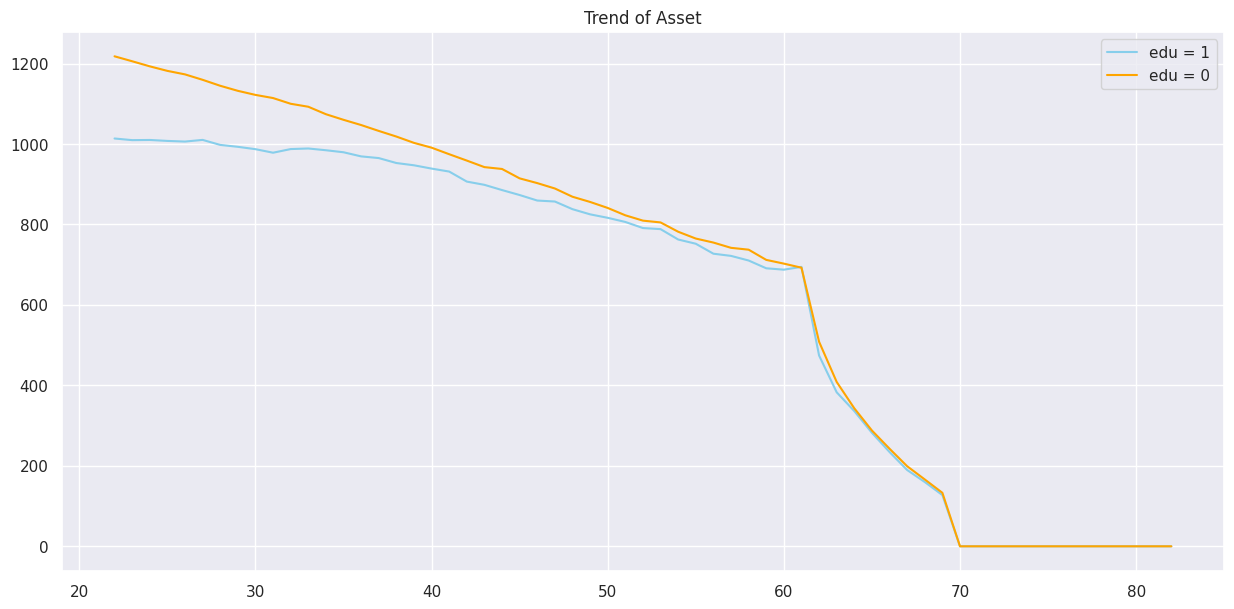

In [48]:

plot_trend(all_h, all_edu, None, 'Asset')

In [46]:
def plot_trend(data, edu, mask_retirement, type, plots_base_dir= None, epoch = None, save = False):
    
    plt.figure(figsize=(15,7))
    
    
    # if type in ['Income', 'Work_Hour']:
    #     weights_edu_0 = torch.concat( [torch.ones((T_ER - AGE_0)) * len(data[edu<=0]) , mask_retirement[edu<=0].sum(dim=0)], dim = 0) 
    #     weights_edu_1 = torch.concat( [torch.ones((T_ER - AGE_0)) * len(data[edu>0]) , mask_retirement[edu>0].sum(dim=0)], dim = 0) 
        
    #     plt.plot( data[edu > 0][:,:T_LR].sum(dim=0)/weights_edu_1, color='skyblue', label='edu = 1')
    #     plt.plot( data[edu <= 0][:,:T_LR].sum(dim=0)/weights_edu_0, color='orange', label='edu = 0')
        
    #     plt.xticks(AGE_0, T_LR+1)

    # elif type in ['Consumption', 'Asset']:
    plt.plot( range(AGE_0, len(data[0]) + AGE_0), data[edu > 0].median(dim=0).values, color='skyblue', label='edu = 1')
    plt.plot( range(AGE_0, len(data[0]) + AGE_0), data[edu <= 0].median(dim=0).values, color='orange', label='edu = 0')
        # plt.xticks())
    
    plt.legend()
    plt.title(f'Trend of {type}') 
    if save:
        plt.savefig(f'{plots_base_dir}/epoch{epoch}/trend/trend_{type}.png')
        plt.close()

In [7]:
def Histograms_Individual_Ages(data, edu, type, plots_base_dir = None, epoch = None, save = False):
    
    # print('g')
    
    flag = type in ['Consumption', 'Asset']
        
    fig, ax = plt.subplots(1, 3+flag, figsize=(20,5))
    fig.suptitle('Histogram of {} for ages 25, 40, and 55')
    ax[0].hist(data[edu > 0][:,25 - AGE_0].view(-1), bins=400,  edgecolor='skyblue', alpha= .2, label='edu = 1')
    ax[0].hist(data[edu <= 0][:,25 - AGE_0].view(-1), bins=400,  edgecolor='orange', alpha= .1, label='edu = 0')
    ax[0].set_title('Age 25')
    
    
    ax[1].hist(data[edu > 0][:,40 - AGE_0].view(-1), bins=400,  edgecolor='skyblue', alpha= .2, label='edu = 1')
    ax[1].hist(data[edu <= 0][:,40 - AGE_0].view(-1), bins=400,  edgecolor='orange', alpha= .1, label='edu = 0')
    ax[1].set_title('Age 40')
    
    ax[2].hist(data[edu > 0][:,55 - AGE_0].view(-1), bins=400,  edgecolor='skyblue', alpha= .2, label='edu = 1')
    ax[2].hist(data[edu <= 0][:,55 - AGE_0].view(-1), bins=400,  edgecolor='orange', alpha= .1, label='edu = 0')
    ax[2].set_title('Age 55')
    
    
    if flag:
        ax[3].hist(data[edu > 0][:,75 - AGE_0].view(-1), bins=400,  edgecolor='skyblue', alpha= .1, label='edu = 1')
        ax[3].hist(data[edu <= 0][:,75 - AGE_0].view(-1), bins=400,  edgecolor='orange', alpha= .1, label='edu = 0')
        ax[3].set_title('Age 75')
        
    
    plt.legend()
    if save:
        plt.savefig(f'{plots_base_dir}/epoch{epoch}/histograms/hist_{type}_25_40_55.png')
        plt.close()
        return 
    # plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plt.title('trend asset for model')

ax[0].plot( np.arange(AGE_0, T_D+1),  all_c[all_edu>0].mean(dim=0), label='edu=1')
ax[0].plot( np.arange(AGE_0, T_D+1),  all_c[all_edu<=0].mean(dim=0), label='edu=0')
ax[0].set_title('model')


# ax[1].plot( np.arange(AGE_0, T_D+2),  all_a_s[all_edu_s>0].mean(dim=0), label='edu=1')
# ax[1].plot( np.arange(AGE_0, T_D+2),  all_a_s[all_edu_s<=0].mean(dim=0), label='edu=0')
# ax[1].set_title('model steep')

# ax[2].plot( np.arange(AGE_0, T_D+1),  all_c_s_phi0[all_edu_s_phi0>0].mean(dim=0), label='edu=1')
# ax[2].plot( np.arange(AGE_0, T_D+1),  all_c_s_phi0[all_edu_s_phi0<=0].mean(dim=0), label='edu=0')
# ax[2].set_title('model steep and phi=0')

plt.xlim( (AGE_0, T_D+2))
plt.xticks( np.arange(AGE_0, T_D+2, 5))
# plt.title('trend asset for model')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


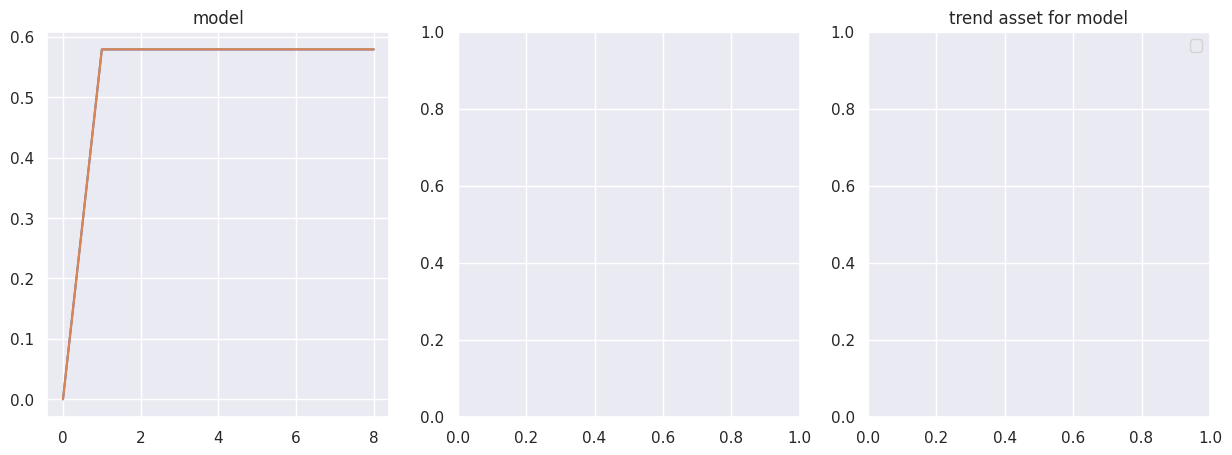

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plt.title('trend asset for model')

ax[0].plot(  all_p[all_edu>0].mean(dim=0), label='edu=1')
ax[0].plot(  all_p[all_edu<=0].mean(dim=0), label='edu=0')
ax[0].set_title('model')


# ax[1].plot(  all_p_s[all_edu_s>0].mean(dim=0), label='edu=1')
# ax[1].plot(  all_p_s[all_edu_s<=0].mean(dim=0), label='edu=0')
# ax[1].set_title('model steep')

# ax[2].plot( all_p_s_phi0[all_edu_s_phi0>0].mean(dim=0), label='edu=1')
# ax[2].plot( all_p_s_phi0[all_edu_s_phi0<=0].mean(dim=0), label='edu=0')
# ax[2].set_title('model steep and phi=0')


# plt.xticks( np.arange(AGE_0, T_D+2, 5))/
# plt.title('trend asset for model')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plt.title('trend asset for model')

ax[0].plot( np.arange(AGE_0, T_D+1),  all_h[all_edu>0].mean(dim=0), label='edu=1')
ax[0].plot( np.arange(AGE_0, T_D+1),  all_h[all_edu<=0].mean(dim=0), label='edu=0')
ax[0].set_title('model')


# ax[1].plot( np.arange(AGE_0, T_D+1),  all_h_s[all_edu_s>0].mean(dim=0), label='edu=1')
# ax[1].plot( np.arange(AGE_0, T_D+1),  all_h_s[all_edu_s<=0].mean(dim=0), label='edu=0')
# ax[1].set_title('model steep')

# ax[2].plot( np.arange(AGE_0, T_D+1),  all_h_s_phi0[all_edu_s_phi0>0].mean(dim=0), label='edu=1')
# ax[2].plot( np.arange(AGE_0, T_D+1),  all_h_s_phi0[all_edu_s_phi0<=0].mean(dim=0), label='edu=0')
# ax[2].set_title('model steep and phi=0')

plt.xlim( (AGE_0, T_D+2))
plt.xticks( np.arange(AGE_0, T_D+1, 5))
# plt.title('trend asset for model')
plt.legend()
plt.show()

In [ ]:
all_p[all_edu>0][:,4]

In [ ]:
all_p_s[all_edu_s>0][:,7].max()